<div>
<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px" width=100>
</div>

# Project 2: Ames Housing Data and Kaggle Challenge

## Background
The Ames Housing Dataset is an exceptionally detailed and robust dataset with over 70 columns of different features relating to houses.  
We are presented with this dataset to predict the prices of the houses in Ames, Iowa.  
The data is taken  from: https://www.kaggle.com/c/dsi-us-11-project-2-regression-challenge/data

## Problem Statement
As a consultant to a potential house-owner in the city of Ames of Iowa, I am presented with the challenge of finding the features that will affect the sale price of the house. In doing so, I will then be able to give recommendations to the potential house-owner on the features that will affect the value of the house the most, and in doing so, help the potential house-owner in judging what sort of house to look for based on the available budget.

## Progress thus far
In Part 1, we have cleaned the provided datasets and selected the following features out of the original 80 features that will be used for our modelling process. Do note that some of the features are actually dummy features created from the original data columns.

|Feature|Data Type|Description|
|:--:|:--:|:----------:|
|**lot_frontage**| Continuous | Linear feet of street connected to property |
|**lot_area**| Continuous | Lot size in square feet |
|**overall_qual**| Ordinal | The overall rating of the material and finish of the house |
|**year_built**| Discrete | Original construction date |
|**exter_qual**| Ordinal | The evaluated quality of the material on the exterior |
|**bsmt_qual**| Ordinal | The evaluated height of the basement |
|**bsmt_exposure**| Ordinal | Refers to walkout or garden level walls with split levels or foyers scoring average |
|**total_bsmt_sf**| Continuous | Total square feet of basement area |
|**heating_qc**| Ordinal | Heating quality and condition |
|**gr_liv_area**| Contiuous | Above grade (ground) living area square feet |
|**full_bath**| Discrete | Full bathrooms above grade |
|**kitchen_qual**| Ordinal | Kitchen Quality |
|**totrms_abvgrd**| Discrete | Total rooms above grade (does not include bathrooms) |
|**fireplaces**| Discrete | Number of fireplaces |
|**garage_area**| Continuous | Size of garage in square feet |
|**neighborhood_stonebr**| Dummy (Nominal) | Stone Brook (Physical location within Ames city limits) |
|**neighborhood_nridght**| Dummy (Nominal) | Northridge Heights (Physical location within Ames city limits) |
|**neighborhood_noridge**| Dummy (Nominal) | Northridge (Physical location within Ames city limits) |
|**bsmt_fin_glq**| Dummy (Ordinal) | Rating of basement finished area as Good Living Quarters |
|**garage_builtin**| Dummy (Nominal) | Location of Garage being built-in as part of house |
|**garage_attchd**| Dummy (Nominal) | Location of Garage being attached to home |
|**foundation_pconc**| Dummy (Nominal) | Type of foundation as Poured Concrete |
|**house_1story**| Dummy (Nominal) | One story (Style of dwelling) |
|**house_2story**| Dummy (Nominal) | Two story (Style of dwelling) |
|**masvnr_stone**| Dummy (Nominal) | Masonry veneer type of Stone |
|**masvnr_brkface**| Dummy (Nominal) | Masonry veneer type of Brick Face|

## Part 2: Modelling

### 1. Importing the libraries (All libraries used will be added here)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 2. Importing the training dataset and the test dataset

In [2]:
df_train_clean = pd.read_csv('../datasets/train_clean.csv')

df_test_clean = pd.read_csv('../datasets/test_clean.csv')

### 3. Train/Test Split
As we are unable to confirm the results of our modelling if we are to immediately predict on the test dataset since the `SalePrice` for the test dataset is not provided, if we are to evaluate our models, we will have to split up the training dataset into train data and test data.

In [3]:
# Determining the features for the modelling
features = [feat for feat in df_train_clean.columns if feat != 'saleprice' and feat != 'id']

In [4]:
# Creating the X and y variables from the training dataset
X = df_train_clean[features]
y = df_train_clean['saleprice']

# Creating the X variable from the test dataset [Using X_kaggle here to differ from the X_test later]
X_kaggle = df_test_clean[features]

# Displaying the shapes of the X and y variables
display(X.shape)
display(y.shape)
display(X_kaggle.shape)

(2051, 26)

(2051,)

(878, 26)

In [5]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

### 4. Baseline Model
For the Baseline Model for the prediction of the `SalePrice`, we will be using the mean value of `SalePrice` from the train data above as the predictions for the test data.

In [6]:
# The mean value of SalePrice
np.mean(y_train)

181061.9934980494

In [7]:
# RMSE for the train data
y_pred_base = np.ones_like(y_train) * np.mean(y_train)
np.sqrt(mean_squared_error(y_train, y_pred_base))

79526.85223710592

In [8]:
# RMSE for the test data
y_pred_base = np.ones_like(y_test) * np.mean(y_train)
np.sqrt(mean_squared_error(y_test, y_pred_base))

78375.26238032707

For the Baseline Model, the RMSE for the train set and the test set are 79526.8522 and 78375.2624 respectively. Considering the RMSE for the sample provided by Kaggle is at 83945.31, this is somewhat expected for the Baseline Model.

From here on, we just have to improve on this score by modelling the data on the appriopriate models.

|Model|Train/Test **RMSE**|
|:--:|:--:|
|**Baseline**|79526.8522 / 78375.2624|

### 5. Model Fitting and Evaluation
At this point in time, we will be fitting the given data to a multi-variable linear regression model. As we have checked the linear relationships in Part 1, we will not be doing these here again. 

Also, to evaluate the models, we will be looking at the three metrics: _Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) and Coefficient of Determination, $R^2$_.

In [9]:
# Function for metrics (Since we will be using this often)
def model_metrics(model, X_mod, y_mod):
    # Predicting the y values based on the given X_mod
    y_mod_pred = model.predict(X_mod)       
    
    # Printing the metrics data
    print(f'RMSE: {round(np.sqrt(mean_squared_error(y_mod, y_mod_pred)), 4)}')
    print(f'MAE: {round(mean_absolute_error(y_mod, y_mod_pred), 2)}')
    print(f'R2: {round(r2_score(y_mod, y_mod_pred), 4)}')

In [10]:
# Function for cross val score (Since we will be using this often)
def model_crossval(model, X_mod, y_mod, cv_mod=5):
    # Printing the cross val scores
    print(f'RMSE: {round(np.sqrt(-cross_val_score(model, X_mod, y_mod, scoring="neg_mean_squared_error", cv=cv_mod).mean()), 4)}')
    print(f'R2: {round(cross_val_score(model, X_mod, y_mod, cv=cv_mod).mean(), 4)}')

In [11]:
# Function for the plot of predicted values versus actual values
def model_plot(model, X_mod, y_mod):
    # Predicting the y values based on the given X_mod
    y_mod_pred = model.predict(X_mod)  
    
    plt.figure(figsize = [12, 6])                                                    # Determine figure size
    plt.title('Actual Sale Price versus Predicted Sale Price', fontsize = 12)                # Title of Plot
    plt.xlabel('Actual Sale Price')
    plt.ylabel('Predicted Sale Price')
    sns.regplot(x = y_mod, y = y_mod_pred, line_kws = {"color": "red"})              # Plot of Actual vs Predicted

### 5.1 Scaling of data
As our later models using Ridge and Lasso would require us to scale our data prior to modelling, we will be scaling the features in our dataset

In [12]:
# The columns that need to be scaled, taken from Part 1, dummy columns do not need to be scaled
scale_cols = ['lot_frontage',
              'lot_area',
              'overall_qual', 
              'year_built', 
              'exter_qual', 
              'bsmt_qual', 
              'bsmt_exposure', 
              'total_bsmt_sf', 
              'heating_qc', 
              'gr_liv_area', 
              'full_bath', 
              'kitchen_qual', 
              'totrms_abvgrd', 
              'fireplaces', 
              'garage_area']

In [13]:
# Initializing the scaled dataframes in order to avoid the transformation of the original dataframes
Z_train = X_train.copy()
Z_test = X_test.copy()
Z_kaggle = X_kaggle.copy()

In [14]:
# Initializing the StandardScaler
ss = StandardScaler()

# Fit and transform the training data
Z_train[scale_cols] = ss.fit_transform(Z_train[scale_cols])

#Transform the testing data and the kaggle test dataset
Z_test[scale_cols] = ss.transform(Z_test[scale_cols])
Z_kaggle[scale_cols] = ss.transform(Z_kaggle[scale_cols])

### 5.2 Linear Regression
Our first model to start off will be the Ordinary Least Squares Linear Regression or OLS. 

Since we have both the scaled and the unscaled data to model from, we will be using both here as well.

In [15]:
## Unscaled data
# Initializing and fitting the model 
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [16]:
# Metrics for Linear Regression with Unscaled data for the training data
model_metrics(lr, X_train, y_train)

RMSE: 30818.775
MAE: 19916.61
R2: 0.8498


In [17]:
# Metrics for Linear Regression with Unscaled data for the test data
model_metrics(lr, X_test, y_test)

RMSE: 26866.9156
MAE: 19634.45
R2: 0.8824


In [18]:
# Cross validation score for Linear Regression with Unscaled data
model_crossval(lr, X_train, y_train, cv_mod=10)

RMSE: 32499.3382
R2: 0.8313


In [19]:
# Coefficients of Linear Regression with Unscaled data
lr.coef_

array([ 5.64082182e+01,  1.16274160e+00,  1.10626827e+04,  1.34173332e+02,
        1.09954460e+04,  5.34192164e+03,  6.38570224e+03, -3.05053562e+00,
        3.47235273e+03,  5.22221215e+01, -1.30589430e+03,  9.77599193e+03,
        5.26111097e+02,  8.74988108e+03,  2.62663648e+01,  6.11416614e+04,
        4.39979922e+04,  3.76673296e+04,  8.30230319e+03,  2.29517406e+03,
        1.47164667e+03, -6.82043785e+02,  1.17280622e+04, -4.08175975e+03,
        5.97043275e+03, -5.83126867e+01])

The R2 scores for both the training and test data are 0.8498 and 0.8824 respectively, which is good since we are looking at how well the model is performing. The MAE scores for both the training and test data are 19916.6098 and 19634.4543 respectively, which is not very good. However the cross validation score of 0.8313 differs quite a bit from the R2 score, so the model does not work so well on unseen data and it is overfitting.

The RMSE for the train and test data are at 30818.775 and 26866.9156 respectively, which is an improvement from the baseline scores. However, as above, it should be noted that the cross validation score with RMSE is at 32499.3382, means that this model does not do well with unseen data.

|Model|Train/Test **RMSE**| Train/Test **MAE**| Train/Test **R2**|Cross val **RMSE**|Cross val **R2**|
|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|79526.8522 / 78375.2624| -- | -- | -- | -- |
|**Linear Regression (Unscaled)**| 30818.775 / 26866.9156 | 19916.61 / 19634.45 | 0.8498 / 0.8824 | 32499.3382 | 0.8313 |

In [20]:
## Scaled data
# Initializing and fitting the model 
lr_ss = LinearRegression()
lr_ss.fit(Z_train, y_train)

LinearRegression()

In [21]:
# Metrics for Linear Regression with Scaled data for the training data
model_metrics(lr_ss, Z_train, y_train)

RMSE: 30818.775
MAE: 19916.61
R2: 0.8498


In [22]:
# Metrics for Linear Regression with Scaled data for the test data
model_metrics(lr_ss, Z_test, y_test)

RMSE: 26866.9156
MAE: 19634.45
R2: 0.8824


In [23]:
# Cross validation score for Linear Regression with Scaled data
model_crossval(lr_ss, Z_train, y_train, cv_mod=10)

RMSE: 32499.3382
R2: 0.8313


In [24]:
# Coefficients of Linear Regression with Scaled data
lr_ss.coef_

array([ 1.16928996e+03,  5.69709787e+03,  1.57979260e+04,  4.04720864e+03,
        6.41481085e+03,  4.77414310e+03,  6.82184421e+03, -1.38869463e+03,
        3.38341569e+03,  2.58949006e+04, -7.22278307e+02,  6.52032942e+03,
        8.21861186e+02,  5.56879470e+03,  5.73119597e+03,  6.11416614e+04,
        4.39979922e+04,  3.76673296e+04,  8.30230319e+03,  2.29517406e+03,
        1.47164667e+03, -6.82043785e+02,  1.17280622e+04, -4.08175975e+03,
        5.97043275e+03, -5.83126867e+01])

We have the exact same scores for both unscaled and scaled data. This should not be a surprise since scaling only standardizes the X values and does not affect the modelling in any way. The only difference is the coefficients of the model due to the scaling.

|Model|Train/Test **RMSE**| Train/Test **MAE**| Train/Test **R2**|Cross val **RMSE**|Cross val **R2**|
|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|79526.8522 / 78375.2624| -- | -- | -- | -- |
|**Linear Regression**| 30818.775 / 26866.9156 | 19916.61 / 19634.45 | 0.8498 / 0.8824 | 32499.3382 | 0.8313 |


### 5.3 Ridge Regression
The next step is regularization. First off, we will start with Ridge Regression.

In [25]:
# Initializing and fitting the model 
r_alphas = np.logspace(0,5,100)
ridge_cv = RidgeCV(alphas=r_alphas, cv=10)
ridge_cv.fit(Z_train,y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=10)

In [26]:
# Optimal value of alpha 
ridge_cv.alpha_

2.8480358684358014

In [27]:
# Initiate and fitting Ridge with the optimal value of alpha
ridge = Ridge(alpha=ridge_cv.alpha_)
ridge.fit(Z_train, y_train)

Ridge(alpha=2.8480358684358014)

In [28]:
# Metrics for Ridge for the training data
model_metrics(ridge, Z_train, y_train)

RMSE: 30837.174
MAE: 19898.7
R2: 0.8496


In [29]:
# Metrics for Ridge for the test data
model_metrics(ridge, Z_test, y_test)

RMSE: 26679.0112
MAE: 19612.71
R2: 0.8841


In [30]:
# Cross validation score for Ridge Regression for the training data
model_crossval(ridge, Z_train, y_train, cv_mod=10)

RMSE: 32500.1995
R2: 0.8315


The R2 scores for both the training and test data are 0.8496 and 0.8841 respectively, indicating the model is doing slightly better than before. The MAE scores for both the training and test data are 19898.7 and 19612.71 respectively as well. Also, the cross validation score of 0.8315 means this is improving on the previous model.

The RMSE for the train and test data are at 30837.174 and 26679.0112 respectively, indicates that there is some mitigation to the overfitting of the model. However, the cross validation score with RMSE is at 32500.1995 indicates little improvement in the area of overfitting.

|Model|Train/Test **RMSE**| Train/Test **MAE**| Train/Test **R2**|Cross val **RMSE**|Cross val **R2**|
|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|79526.8522 / 78375.2624| -- | -- | -- | -- |
|**Linear Regression**| 30818.775 / 26866.9156 | 19916.61 / 19634.45 | 0.8498 / 0.8824 | 32499.3382 | 0.8313 |
|**Ridge Regression**| 30837.174 / 26679.0112 | 19898.7 / 19612.71 | 0.8496 / 0.8841 | 32500.1995 | 0.8315 |

### 5.4 Lasso Regression
After Ridge Regression, we will try Lasso Regression.

In [31]:
# Initializing and fitting the model 
lasso_cv = LassoCV(n_alphas=500, cv=10)
lasso_cv.fit(Z_train,y_train)

LassoCV(cv=10, n_alphas=500)

In [32]:
# Optimal value of alpha 
lasso_cv.alpha_

143.23048922825134

In [33]:
# Initiate and fitting Lasso with the optimal value of alpha
lasso = Lasso(alpha=lasso_cv.alpha_)
lasso.fit(Z_train, y_train)

Lasso(alpha=143.23048922825134)

In [34]:
# Metrics for Lasso for the training data
model_metrics(lasso, Z_train, y_train)

RMSE: 30890.5437
MAE: 19807.77
R2: 0.8491


In [35]:
# Metrics for Lasso for the test data
model_metrics(lasso, Z_test, y_test)

RMSE: 26499.4763
MAE: 19494.47
R2: 0.8856


In [36]:
# Cross validation score for Lasso Regression for the training data
model_crossval(lasso, Z_train, y_train, cv_mod=10)

RMSE: 32413.1619
R2: 0.8326


The R2 scores for both the training and test data are 0.8491 and 0.8856, indicating the model is doing slightly better than the previous two models with regards to the fitting. Also, the cross validation score of 0.8326 means this is improving on the previous models.

The RMSE for the train and test data are at 30890.5437 and 26499.4763 respectively, indicates that there is some mitigation to the overfitting of the model. However, the cross validation score with RMSE is at 32413.1619 indicates some improvement in the area of overfitting.

|Model|Train/Test **RMSE**| Train/Test **MAE**| Train/Test **R2**|Cross val **RMSE**|Cross val **R2**|
|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|79526.8522 / 78375.2624| -- | -- | -- | -- |
|**Linear Regression**| 30818.775 / 26866.9156 | 19916.61 / 19634.45 | 0.8498 / 0.8824 | 32499.3382 | 0.8313 |
|**Ridge Regression**| 30837.174 / 26679.0112 | 19898.7 / 19612.71 | 0.8496 / 0.8841 | 32500.1995 | 0.8315 |
|**Lasso Regression**| 30890.5437 / 26499.4763 | 19807.77 / 19494.47 | 0.8491 / 0.8856 | 32413.1619 | 0.8326 |

In [37]:
# Displaying the coefficients of lasso
lasso_coef = pd.DataFrame({'feature': X.columns,
                          'coef': lasso.coef_,
                          'abs_coef':np.abs(lasso.coef_)})
lasso_coef.sort_values('abs_coef', ascending=False)

,feature,coef,abs_coef
15,neighborhood_stonebr,51973.166787,51973.166787
16,neighborhood_nridght,39732.023002,39732.023002
17,neighborhood_noridge,29588.080102,29588.080102
9,gr_liv_area,25506.574176,25506.574176
2,overall_qual,16167.605753,16167.605753
22,house_1story,10840.294766,10840.294766
18,bsmt_fin_glq,7703.587228,7703.587228
6,bsmt_exposure,6808.148701,6808.148701
11,kitchen_qual,6761.540518,6761.540518
4,exter_qual,6709.092386,6709.092386


### 5.5 Polynomial Features
At this point in time, our best model is the Lasso Regression model.

Next, we will attempt to see if generating interaction terms might get us better results.

#### 5.5.1 Using self-generated interaction terms on the Lasso Regression model

In [38]:
# Checking the correlation with 'saleprice'
feat_corr = df_train_clean.corr()['saleprice']
feat_corr.abs().sort_values(ascending=False)

saleprice               1.000000
overall_qual            0.800207
exter_qual              0.712146
gr_liv_area             0.709702
kitchen_qual            0.692336
garage_area             0.650246
total_bsmt_sf           0.629303
bsmt_qual               0.612188
year_built              0.571849
full_bath               0.537969
foundation_pconc        0.529047
totrms_abvgrd           0.504014
fireplaces              0.471093
bsmt_fin_glq            0.463549
heating_qc              0.458354
neighborhood_nridght    0.448647
bsmt_exposure           0.424863
lot_area                0.361831
garage_attchd           0.357879
lot_frontage            0.340446
masvnr_stone            0.310026
neighborhood_noridge    0.263395
masvnr_brkface          0.257901
neighborhood_stonebr    0.256977
garage_builtin          0.219820
house_2story            0.201911
id                      0.051398
house_1story            0.021652
Name: saleprice, dtype: float64

Looking at the large coefficient terms for the three types of neighbourhood, and then the small coefficient terms for `Lot Area` and `Lot Frontage` from the Lasso Regression Model, and looking at the relatively low correlation above, these will be the newly generated interaction terms that we have selected for the new model.

In [39]:
# Function to create interaction terms for the dataframe
def interact_df(dataframe):
    
    # Creating the new interaction terms with Lot Area and the three neighbourhoods
    dataframe['neighborhood_stonebr * lot_area'] = dataframe['neighborhood_stonebr'] * dataframe['lot_area']
    dataframe['neighborhood_nridght * lot_area'] = dataframe['neighborhood_nridght'] * dataframe['lot_area']
    dataframe['neighborhood_noridge * lot_area'] = dataframe['neighborhood_noridge'] * dataframe['lot_area']
        
    # Creating the new interaction terms with Lot Frontage and the three neighbourhoods
    dataframe['neighborhood_stonebr * lot_frontage'] = dataframe['neighborhood_stonebr'] * dataframe['lot_frontage']
    dataframe['neighborhood_nridght * lot_frontage'] = dataframe['neighborhood_nridght'] * dataframe['lot_frontage']
    dataframe['neighborhood_noridge * lot_frontage'] = dataframe['neighborhood_noridge'] * dataframe['lot_frontage']
  
    return dataframe

In [40]:
# Adding the interaction terms to the dataframes
Z_train_interact = interact_df(dataframe = Z_train.copy())
Z_test_interact = interact_df(dataframe = Z_test.copy())

In [41]:
# Initializing and fitting the model 
lasso_cv_interact = LassoCV(n_alphas=500, cv=10)
lasso_cv_interact.fit(Z_train_interact,y_train)

LassoCV(cv=10, n_alphas=500)

In [42]:
# Optimal value of alpha 
lasso_cv_interact.alpha_

245.75616043115068

In [43]:
# Initiate and fitting Lasso with poly with the optimal value of alpha
lasso_interact = Lasso(alpha=lasso_cv_interact.alpha_)
lasso_interact.fit(Z_train_interact, y_train)

Lasso(alpha=245.75616043115068)

In [44]:
# Metrics for Lasso with poly for the training data
model_metrics(lasso_interact, Z_train_interact, y_train)

RMSE: 28784.1962
MAE: 18938.95
R2: 0.869


In [45]:
# Metrics for Lasso with poly for the test data
model_metrics(lasso_interact, Z_test_interact, y_test)

RMSE: 25083.6057
MAE: 18487.04
R2: 0.8975


In [46]:
# Cross validation score for Lasso Regression with poly for the training data
model_crossval(lasso_interact, Z_train_interact, y_train, cv_mod=10)

RMSE: 30763.6683
R2: 0.8484


The R2 scores for both the training and test data are 0.869 and 0.8975 respectively. Also, the cross validation score of 0.8484 means the act of adding interaction terms has made the model more accurate at predicting the `SalePrice`.

The RMSE for the train and test data are at 28784.1962 and 25083.6057 respectively. Also, the cross validation score with RMSE is at 30763.6683 indicates the act of adding more interaction terms has made the model more accurate than before.

|Model|Train/Test **RMSE**| Train/Test **MAE**| Train/Test **R2**|Cross val **RMSE**|Cross val **R2**| No. of Features|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|79526.8522 / 78375.2624| -- | -- | -- | -- | 26 |
|**Linear Regression**| 30818.775 / 26866.9156 | 19916.61 / 19634.45 | 0.8498 / 0.8824 | 32499.3382 | 0.8313 | 26 |
|**Ridge Regression**| 30837.174 / 26679.0112 | 19898.7 / 19612.71 | 0.8496 / 0.8841 | 32500.1995 | 0.8315 | 26 |
|**Lasso Regression**| 30890.5437 / 26499.4763 | 19807.77 / 19494.47 | 0.8491 / 0.8856 | 32413.1619 | 0.8326 | 26 |
|**Lasso Regression (interaction terms)**| 28784.1962 / 25083.6057 | 18938.95 / 18487.04 | 0.869 / 0.8975 | 30763.6683 | 0.8484 | 32 |

In [47]:
# Displaying the coefficients of lasso model with interaction terms
interact_coef = pd.DataFrame({'feature': Z_train_interact.columns,
                          'coef': lasso_interact.coef_,
                          'abs_coef':np.abs(lasso_interact.coef_)})
interact_coef.sort_values('abs_coef', ascending=False)

,feature,coef,abs_coef
27,neighborhood_nridght * lot_area,40175.840555,40175.840555
15,neighborhood_stonebr,35170.605063,35170.605063
26,neighborhood_stonebr * lot_area,33118.463030,33118.463030
16,neighborhood_nridght,26855.775796,26855.775796
9,gr_liv_area,25338.149103,25338.149103
17,neighborhood_noridge,17186.963128,17186.963128
2,overall_qual,16392.860313,16392.860313
28,neighborhood_noridge * lot_area,15520.623040,15520.623040
22,house_1story,11477.383130,11477.383130
18,bsmt_fin_glq,8087.091292,8087.091292


#### 5.5.2 Lasso with Polynomial Features
Since we have done modelling with interaction terms generated by ourselves, let's try the brute-force method with `PolynomialFeatures`. [Note that this is not a very feasible method as a lot of feature columns are generated]

In [48]:
# Initializing the PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform the scaled training data
Z_train_poly = poly.fit_transform(Z_train)

#Transform the scaled testing data and the scaled kaggle test dataset
Z_test_poly = poly.transform(Z_test)
Z_kaggle_poly = poly.transform(Z_kaggle)

In [49]:
# Shape of the new Z variable
Z_train_poly.shape

(1538, 377)

In [50]:
# Initializing and fitting the model 
lasso_cv_poly = LassoCV(n_alphas=500, cv=10)
lasso_cv_poly.fit(Z_train_poly,y_train)

LassoCV(cv=10, n_alphas=500)

In [51]:
# Optimal value of alpha 
lasso_cv_poly.alpha_

302.4717186002478

In [52]:
# Initiate and fitting Lasso with poly with the optimal value of alpha
lasso_poly = Lasso(alpha=lasso_cv_poly.alpha_)
lasso_poly.fit(Z_train_poly, y_train)

Lasso(alpha=302.4717186002478)

In [53]:
# Metrics for Lasso with poly for the training data
model_metrics(lasso_poly, Z_train_poly, y_train)

RMSE: 21398.005
MAE: 14962.62
R2: 0.9276


In [54]:
# Metrics for Lasso with poly for the test data
model_metrics(lasso_poly, Z_test_poly, y_test)

RMSE: 22423.2328
MAE: 16136.06
R2: 0.9181


In [55]:
# Cross validation score for Lasso Regression with poly for the training data
model_crossval(lasso_poly, Z_train_poly, y_train, cv_mod=10)

RMSE: 27024.0471
R2: 0.8866


The R2 scores for both the training and test data are 0.9276 and 0.9181 respectively. Also, the cross validation score of 0.8866 means the act of creating the polynominal features has made the model more accurate at predicting the `SalePrice`.

The RMSE for the train and test data are at 21398.005 and 22423.2328 respectively. Also, the cross validation score with RMSE is at 27024.0471 indicates the act of adding more interaction terms than the previous model has made the model more accurate than before.

However, it should be noted that a lot of features are now included which is not feasible for modelling, and many of the coefficients of the features are zero as well.

|Model|Train/Test **RMSE**| Train/Test **MAE**| Train/Test **R2**|Cross val **RMSE**|Cross val **R2**| No. of Features|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|79526.8522 / 78375.2624| -- | -- | -- | -- | 26 |
|**Linear Regression**| 30818.775 / 26866.9156 | 19916.61 / 19634.45 | 0.8498 / 0.8824 | 32499.3382 | 0.8313 | 26 |
|**Ridge Regression**| 30837.174 / 26679.0112 | 19898.7 / 19612.71 | 0.8496 / 0.8841 | 32500.1995 | 0.8315 | 26 |
|**Lasso Regression**| 30890.5437 / 26499.4763 | 19807.77 / 19494.47 | 0.8491 / 0.8856 | 32413.1619 | 0.8326 | 26 |
|**Lasso Regression (interaction terms)**| 28784.1962 / 25083.6057 | 18938.95 / 18487.04 | 0.869 / 0.8975 | 30763.6683 | 0.8484 | 32 |
|**Lasso Regression (polynominal features)**| 21398.005 / 22423.2328 | 14962.62 / 16136.06 | 0.9276 / 0.9181 | 27024.0471 | 0.8866 | 377 |

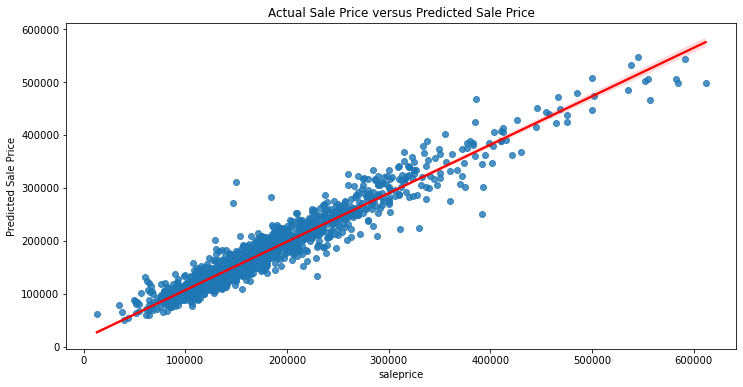

In [56]:
# Plot of the Actual Sale Price vs Predicted Sale Price for the lasso model for the training dataset
model_plot(lasso_poly, Z_train_poly, y_train)

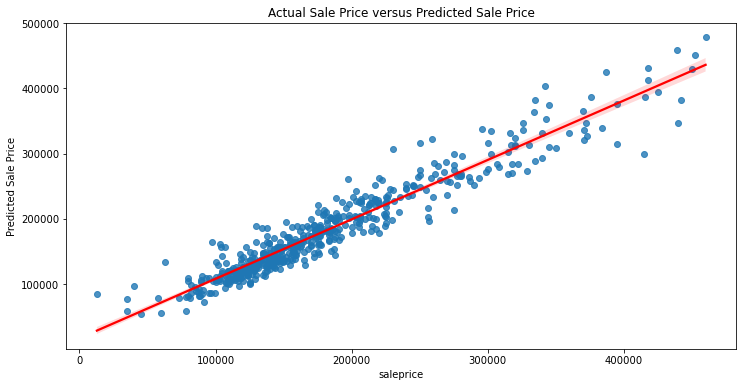

In [57]:
# Plot of the Actual Sale Price vs Predicted Sale Price for the lasso model for the testing dataset
model_plot(lasso_poly, Z_test_poly, y_test)

### 6. Final Model
Based on the results of the previous models, despite the non-feasibility of the model, we can see the Lasso model with Polynomial Features is doing the best. As such, we will be using to fit the entire training dataset in order to predict the `SalePrice` for the test dataframe.

In [58]:
# Initiating the Scaled dataset and scaling
Z = X.copy()
Z[scale_cols] = ss.fit_transform(Z[scale_cols])

# Fit and transform the scaled training data with polynomial features
Z_poly = poly.fit_transform(Z)

# Initializing and fitting the final model 
lasso_cv_final = LassoCV(n_alphas=500, cv=10)
lasso_cv_final.fit(Z_poly, y)

LassoCV(cv=10, n_alphas=500)

In [59]:
# Optimal value of alpha 
lasso_cv_final.alpha_

211.4409932808151

In [60]:
# Initiate and fitting Lasso with the optimal value of alpha
lasso_final = Lasso(alpha=lasso_cv_final.alpha_)
lasso_final.fit(Z_poly, y)

Lasso(alpha=211.4409932808151)

In [61]:
# Metrics for Lasso for the training dataset
model_metrics(lasso_final, Z_poly, y)

RMSE: 21058.2775
MAE: 14806.98
R2: 0.9294


In [62]:
# Cross validation score for Lasso Regression for the training dataset
model_crossval(lasso_final, Z_poly, y, cv_mod=10)

RMSE: 25192.1239
R2: 0.898


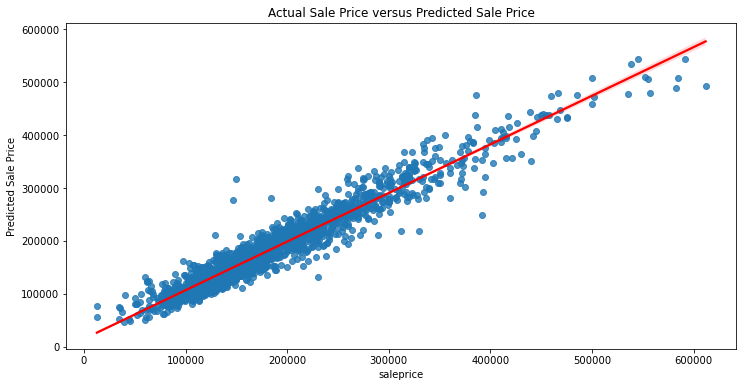

In [63]:
# Plot of the Actual Sale Price vs Predicted Sale Price for the final model for the training dataset
model_plot(lasso_final, Z_poly, y)

The R2 score and the RMSE score for the training dataset are 0.9294 and 21058.2775 respectively, and the cross validation scores with R2 and RMSE scoring are 0.898 and 25192.1239 respectively. These improvements can be related to the increase number of observation data available.

In [64]:
# Predicting using the model on the test dataset
y_kaggle = lasso_final.predict(Z_kaggle_poly)

In [65]:
## Creating the kaggle submission
# Creating the Id column
df_kaggle = pd.DataFrame(df_test_clean, columns=['id'])
df_kaggle.columns = df_kaggle.columns.str.capitalize()

# Creating the predicted SalePrice
df_kaggle['SalePrice'] = y_kaggle

# Sorting by Id
df_kaggle.sort_values(by='Id', inplace=True)

In [66]:
# Exporting the kaggle submission to file
df_kaggle.to_csv('../datasets/kaggle_submission.csv', index=False)

The kaggle submission returned with an RMSE score of 23949.28963, which means that there is some degree of overfitting in the model. But overall, it cannot be denied that this model has been performing the best thus far.

### 7. Recommendations and Conclusion
After generating the final model, we will need to look back at the features themselves as the importance of the features are what we are looking for, and not the accuracy of our model predictions. 

For this analysis, the coefficients of the features in the model are what we will be looking at. The absolute value of the features mean how much it will affect the final sale price.

In [67]:
# Function for Bar Plot for feature vs coefficients 
def bar_feat_coef(dataframe):
    plt.figure(figsize = [12, 6])                                                         # Determine figure size
    plt.title(f'Coefficient vs Feature', fontsize = 12)                                   # Title of Plot
    sns.barplot(x = "coef", y = "feature", data = dataframe)                              # Plot of Feature vs Coefficient

#### 7.1.1 Analysis based on Final Model

In [68]:
## Looking at coefficients of the final model
# Outputting the coefficients to dataframe
final_coef = pd.DataFrame({'feature': poly.get_feature_names_out(features),
                          'coef': lasso_final.coef_,
                          'abs_coef':np.abs(lasso_final.coef_)})

# Looking at the number of non-zero coefficients
display(final_coef[final_coef['abs_coef'] > 0].shape)

# Sort values by absolute value of coefficients and showing the top 20
final_coef.sort_values('abs_coef', ascending=False).head(25)

(126, 3)

,feature,coef,abs_coef
9,gr_liv_area,20708.871066,20708.871066
66,lot_area neighborhood_stonebr,15968.162798,15968.162798
195,total_bsmt_sf neighborhood_stonebr,15627.613651,15627.613651
2,overall_qual,14032.973191,14032.973191
196,total_bsmt_sf neighborhood_nridght,11662.695679,11662.695679
276,totrms_abvgrd neighborhood_nridght,9559.326101,9559.326101
68,lot_area neighborhood_noridge,8129.103372,8129.103372
275,totrms_abvgrd neighborhood_stonebr,6793.332780,6793.332780
1,lot_area,6601.497369,6601.497369
3,year_built,6140.409505,6140.409505


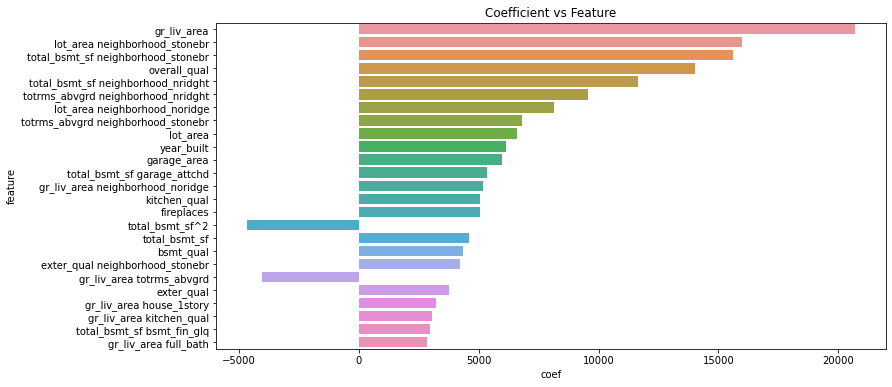

In [69]:
# Creating a dataframe with only the top 25 values
feat_coef = final_coef.sort_values('abs_coef', ascending=False).head(25)

# Plot of feature versus coefficients
bar_feat_coef(feat_coef)

Looking at the coefficients, we can see that there are a lot of zero coefficients, and even just taking a look at the top 25 feature terms, we can see a lot of polynomial features that would make explanations to the house-owner difficult. As such, instead of doing analysis just based on the final model, we will also be looking at the coefficients of the lasso model without all these polynomial features.

For now, just by looking at the non-polynomial features, we can see that the top five terms are `gr_liv_area`, `overall_qual`, `lot_area`, `year_built` and `garage_area`.

It should be noted that evaluation based on the coefficients for the model is not significant. For example, taking the feature of `gr_liv_area`, the coefficient is 20708.871066, which means for every 1 unit increase of `gr_liv_area`, `saleprice` will increase by 20708.871066, which seems impossible at first glance. However, it should be noted that since the data is scaled, the 1 unit increase does not mean 1 square feet increase in `gr_liv_area`.

It should also be noted that among the top polynomial features listed above, most of them are linked to the `three neighborhoods` dummy columns.

|Model|Top Feature 1|Top Feature 2|Top Feature 3|Top Feature 4|Top Feature 5|
|:--:|:--:|:--:|:--:|:--:|:--:|
|**Lasso (Polynomial Features)**|`gr_liv_area`|`overall_qual`|`lot_area`|`year_built`|`garage_area`|

#### 7.1.2 Analysis based on Lasso Regression Model

In [70]:
# Displaying the top 10 coefficients of lasso model again
lasso_coef = lasso_coef.sort_values('abs_coef', ascending=False)
lasso_coef.head(10)

,feature,coef,abs_coef
15,neighborhood_stonebr,51973.166787,51973.166787
16,neighborhood_nridght,39732.023002,39732.023002
17,neighborhood_noridge,29588.080102,29588.080102
9,gr_liv_area,25506.574176,25506.574176
2,overall_qual,16167.605753,16167.605753
22,house_1story,10840.294766,10840.294766
18,bsmt_fin_glq,7703.587228,7703.587228
6,bsmt_exposure,6808.148701,6808.148701
11,kitchen_qual,6761.540518,6761.540518
4,exter_qual,6709.092386,6709.092386


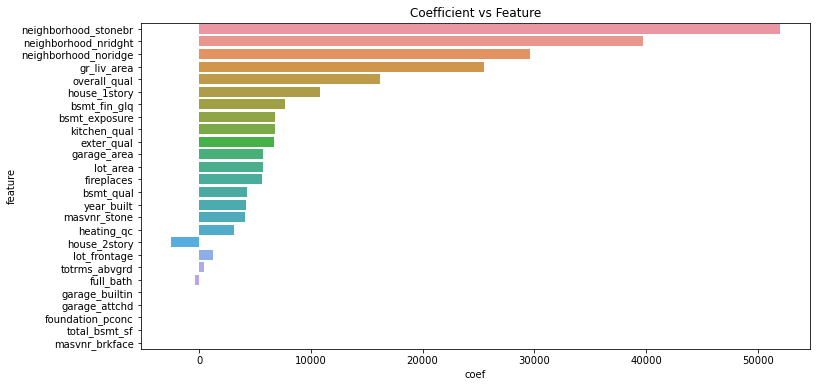

In [71]:
# Plot of feature versus coefficients for the lasso model
bar_feat_coef(lasso_coef)

Look at the coefficients of the Lasso Regression Model, we can see that the top 3 coefficients are for the features that correspond to the `three neighborhoods` we have selected earlier. Following those are the features namely `gr_liv_area`, `overall_qual` and `house_1story`.

|Model|Top Feature 1|Top Feature 2|Top Feature 3|Top Feature 4|Top Feature 5|Top Feature 6|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Lasso (Polynomial Features)**|`gr_liv_area`|`overall_qual`|`lot_area`|`year_built`|`garage_area`| -- |
|**Lasso**|`neighborhood_stonebr`|`neighborhood_nridght`|`neighborhood_noridge`|`gr_liv_area`|`overall_qual`|`house_1story`|

#### 7.1.3 Analysis based on Lasso Regression Model with Interaction Terms

In [72]:
# Displaying the top 10 coefficients of lasso model with interaction terms
interact_coef = interact_coef.sort_values('abs_coef', ascending=False)
interact_coef.head(10)

,feature,coef,abs_coef
27,neighborhood_nridght * lot_area,40175.840555,40175.840555
15,neighborhood_stonebr,35170.605063,35170.605063
26,neighborhood_stonebr * lot_area,33118.463030,33118.463030
16,neighborhood_nridght,26855.775796,26855.775796
9,gr_liv_area,25338.149103,25338.149103
17,neighborhood_noridge,17186.963128,17186.963128
2,overall_qual,16392.860313,16392.860313
28,neighborhood_noridge * lot_area,15520.623040,15520.623040
22,house_1story,11477.383130,11477.383130
18,bsmt_fin_glq,8087.091292,8087.091292


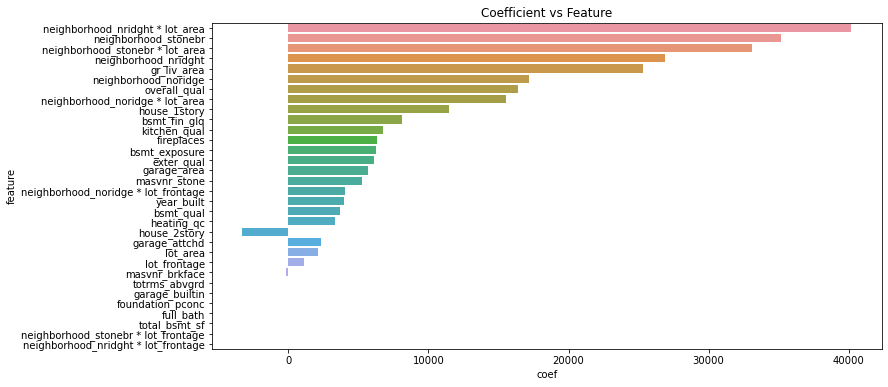

In [73]:
# Plot of feature versus coefficients for the lasso model with interaction terms
bar_feat_coef(interact_coef)

Looking at the coefficients of this model and the previous Lasso model, we can see that the newly added polynomial terms of the `neighborhood` and the `lot area` are now among the the top features. This can be seen from how the `three neighborhoods` are among the top features in the regular lasso model and `lot area` are among the top non-polynomial features in the 

|Model|Top Feature 1|Top Feature 2|Top Feature 3|Top Feature 4|Top Feature 5|Top Feature 6|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Lasso (Polynomial Features)**|`gr_liv_area`|`overall_qual`|`lot_area`|`year_built`|`garage_area`| -- |
|**Lasso**|`neighborhood_stonebr`|`neighborhood_nridght`|`neighborhood_noridge`|`gr_liv_area`|`overall_qual`|`house_1story`|
|**Lasso (interaction terms)**|`neighborhood_nridght * lot_area`|`neighborhood_stonebr`|`neighborhood_stonebr * lot_area`|`neighborhood_nridght`|`gr_liv_area`|`neighborhood_noridge`|

#### 7.1.4 Analysis based on OLS Linear Regression Model
For a comparison, let's also take a look at the coefficients for the original linear regression model as well.

In [74]:
# Displaying the top 10 coefficients of linear regression model with unscaled data
# Outputting the coefficients to dataframe
lr_coef = pd.DataFrame({'feature': X.columns,
                          'coef': lr.coef_,
                          'abs_coef':np.abs(lr.coef_)})

lr_coef = lr_coef.sort_values('abs_coef', ascending=False)
lr_coef.head(10)

,feature,coef,abs_coef
15,neighborhood_stonebr,61141.661357,61141.661357
16,neighborhood_nridght,43997.992241,43997.992241
17,neighborhood_noridge,37667.329617,37667.329617
22,house_1story,11728.062197,11728.062197
2,overall_qual,11062.682744,11062.682744
4,exter_qual,10995.446000,10995.446000
11,kitchen_qual,9775.991926,9775.991926
13,fireplaces,8749.881085,8749.881085
18,bsmt_fin_glq,8302.303195,8302.303195
6,bsmt_exposure,6385.702245,6385.702245


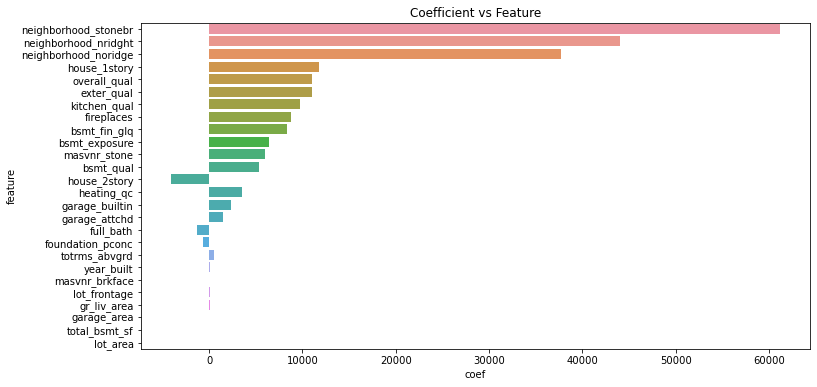

In [75]:
# Plot of feature versus coefficients for the lasso model with interaction terms
bar_feat_coef(lr_coef)

Looking at the coefficients of this model and the previous Lasso models, we can see the `three neighborhoods` are still among the top features. However, it is surprising to note that the features following that are `house_1story`, `overall_qual` and `exter_qual`, with the `gr_liv_area` being dropped to the near bottom. Then again, since `gr_liv_area` has a large magnitude in value, this should not be surprising. In contrast, the features that are ordinal in nature or dummified will thus be likely to have large coefficients. As such, we will skip this analysis for the recommendations.

|Model|Top Feature 1|Top Feature 2|Top Feature 3|Top Feature 4|Top Feature 5|Top Feature 6|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Lasso (Polynomial Features)**|`gr_liv_area`|`overall_qual`|`lot_area`|`year_built`|`garage_area`| -- |
|**Lasso**|`neighborhood_stonebr`|`neighborhood_nridght`|`neighborhood_noridge`|`gr_liv_area`|`overall_qual`|`house_1story`|
|**Lasso (interaction terms)**|`neighborhood_nridght * lot_area`|`neighborhood_stonebr`|`neighborhood_stonebr * lot_area`|`neighborhood_nridght`|`gr_liv_area`|`neighborhood_noridge`|
|**Linear Regression**|`neighborhood_stonebr`|`neighborhood_nridght`|`neighborhood_noridge`|`house_1story`|`gr_liv_area`|`neighborhood_noridge`|

### 7.2 Recommendations

Taking the opportunity to analyze based on the basic _Lasso Regression_ model, the top features are `neighborhood_stonebr`, `neighborhood_nridght`, `neighborhood_noridge`, `gr_liv_area`, `overall_qual` and `house_1story`. And from the analysis on the most accurate model, the _Lasso Regression model with Polynomial Features_, the top non-polynomial features are `gr_liv_area`, `overall_qual`, `lot_area`, `year_built` and `garage_area`.

As such, we will be combining the two lists for the recommendations, giving us `neighborhood_stonebr`, `neighborhood_nridght`, `neighborhood_noridge`, `gr_liv_area`, `overall_qual`, `house_1story`, `lot_area`, `year_built` and `garage_area`. It should be noted that the `three neighborhoods` are mutually exclusive.

|Feature|Description|
|:--:|:----------:|
|**lot_area**| Lot size in square feet |
|**overall_qual**| The overall rating of the material and finish of the house |
|**year_built**| Original construction date |
|**gr_liv_area**| Above grade (ground) living area square feet |
|**garage_area**| Size of garage in square feet |
|**neighborhood_stonebr**| Stone Brook (Physical location within Ames city limits) |
|**neighborhood_nridght**| Northridge Heights (Physical location within Ames city limits) |
|**neighborhood_noridge**| Northridge (Physical location within Ames city limits) |
|**house_1story**| One story (Style of dwelling) |


### 7.3 Conclusion

On the issue of feature engineering, it can be noted from the metrics and coefficients obtained from the models that they can be further refined. The main issue here is that the chosen features are selected based on correlation for the numerical columns and visual plots for the categorical columns, after the columns with too many missing values and the columns with a high proportion of the mode value are dropped. This meant that a lot of features are already dropped prior to the process of modelling.

In the future, perhaps it will be useful to do a quick modelling of the data after a quick data cleaning to drop columns with obvious problems and impute missing data. Then feature engineering can occur to narrow down the features to be selected by analyzing the coefficients of the basic model.

---

Additionally, it should be noted that for the polynomial features added after the feature engineering for additional modeelling, we only did the additions of the few seemingly important features and the use of polynomial features, which is basically a brute-force method. 

In the future, it would be relevant to achieve something in between in the process of refining the model, perhaps a pre-selection of polynomial features that would aid in the modelling process.